# Synaptic terminal plots

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from lib import plot, u

### Reading data

In [3]:
excids = pd.read_csv("data/soma_ids/p100_pyr_soma_IDs_v185.csv", index_col=0
                    ).pt_root_id.tolist()
inhids = pd.read_csv("data/soma_ids/p100_inh_soma_IDs_v185.csv", index_col=0
                    ).pt_root_id.tolist()
somaids = excids + inhids

In [4]:
df_m = pd.read_csv("data/segment_terminal_counts.csv", index_col=0,
                   dtype={"post_pt_root_id":"object",
                          "post_syns":"float64",
                          "id":"int64",
                          "pre_pt_root_id":"object",
                          "pre_syns":"float64"})


def formatidcol(column):
    newcol = list()
    for v in column:
        if isinstance(v, np.float) and np.isnan(v):
            newcol.append(v)
        else:
            try:
                newcol.append(int(v))
            except Exception as e:
                print(v)
                print(type(v))
                raise e
    
    return pd.Series(newcol, dtype="object")


df_m["pre_pt_root_id"] = formatidcol(df_m["pre_pt_root_id"])
df_m["post_pt_root_id"] = formatidcol(df_m["post_pt_root_id"])

/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Plotting

In [5]:
df_exc = df_m[df_m["id"].isin(excids)]
df_inh = df_m[df_m["id"].isin(inhids)]
df_nosoma = df_m[~df_m["id"].isin(somaids)]

In [6]:
df_m.loc[pd.isnull(df_m.post_syns), "type"] = "presyn"
df_m.loc[pd.isnull(df_m.pre_syns), "type"] = "postsyn"
df_m.loc[pd.isnull(df_m["type"]), "type"] = "mixed"
df_m.loc[df_m["id"].isin(somaids), "type"] = "soma"

In [7]:
df_m.head()

,post_pt_root_id,post_syns,id,pre_pt_root_id,pre_syns,type
0,648518346345450394,1.0,648518346345450394,NaN,NaN,postsyn
1,648518346345659230,1.0,648518346345659230,NaN,NaN,postsyn
2,648518346345788377,1.0,648518346345788377,NaN,NaN,postsyn
3,648518346343745756,1.0,648518346343745756,NaN,NaN,postsyn
4,648518346348808231,1.0,648518346348808231,NaN,NaN,postsyn


In [19]:
num_presyn_gte7 = df_m[(df_m.pre_syns >= 10) &
                       (np.isnan(df_m.post_syns))].shape[0]
num_postsyn_gte7 = df_m[(df_m.post_syns >= 10) &
                        (np.isnan(df_m.pre_syns))].shape[0]
print(f"{num_presyn_gte7 + num_postsyn_gte7} neurites with >= 10 synapses")

96450 neurites with >= 10 synapses


In [24]:
gt10 = pd.concat((
         df_m[(df_m.pre_syns >= 10) &
              (np.isnan(df_m.post_syns))],
         df_m[(df_m.post_syns >= 10) &
              (np.isnan(df_m.pre_syns))]))

In [27]:
gt10.head()

,post_pt_root_id,post_syns,id,pre_pt_root_id,pre_syns,type
640932,NaN,NaN,648518346341351458,648518346341351458,24.0,presyn
640936,NaN,NaN,648518346341351467,648518346341351467,42.0,presyn
640944,NaN,NaN,648518346341351496,648518346341351496,18.0,presyn
640951,NaN,NaN,648518346341351503,648518346341351503,18.0,presyn
640952,NaN,NaN,648518346341351504,648518346341351504,10.0,presyn


In [28]:
u.write_ids(gt10["id"].values, "gt10ids.csv")

In [11]:
def stackedhist(df, varname, levels, colors, bins=None,
                levelcolname="type"):
    arrs = [df[varname][df[levelcolname] == level]
            for level in levels]
    
    plt.hist(arrs, bins=bins, color=colors, stacked=True)
    

def stephist(df, varname, levels, colors, bins=None,
             levelcolname="type"):
    arrs = [df[varname][df[levelcolname] == level]
            for level in levels]
    
    for (arr, col) in zip(arrs, colors):
        plt.hist(arr, bins=bins, edgecolor=col, lw=3, histtype="step")
        
        
def alphahist(df, varname, levels, colors, bins=None,
             levelcolname="type"):
    arrs = [df[varname][df[levelcolname] == level]
            for level in levels]
    
    for (arr, col) in zip(arrs, colors):
        plt.hist(arr, bins=bins, color=col, alpha=0.6)


def splithist(df, varname, levels, colors, bins=None,
             levelcolname="type", logx=True, logy=True,
              xlbl="", fontsize=20, ylim=None):
    arrs = [df[varname][df[levelcolname] == level]
            for level in levels]
    print(list(map(len, arrs)))
    
    for (i, (arr, col)) in enumerate(zip(arrs, colors)):
        plt.subplot(1, len(levels), i+1)
        plt.hist(arr, bins=bins, edgecolor=col, color=col)
        
        if i == 0:
            plt.ylabel("Count", fontsize=fontsize)

        if i == 0:
            plt.xlabel(xlbl, fontsize=fontsize)
        
        if logx:
            plt.xscale("log")
        
        if logy:
            plt.yscale("log")
        
        if ylim is None:
            ylim = plt.gca().get_ylim()
            if logy:
                plt.ylim(0.5, ylim[1])
                ylim = (0.5, ylim[1])
        else:
            plt.ylim(*ylim)
            
        plot.format_axes()

[612201, 396]


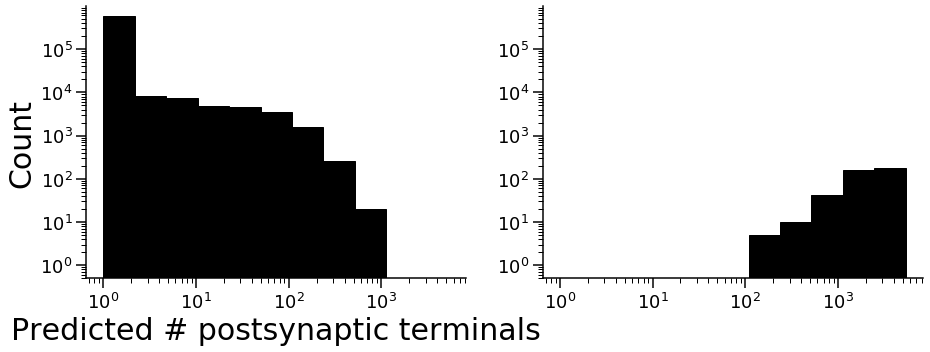

In [23]:
plt.figure(figsize=(15, 5))
bins = u.logspace_bins(df_m.post_syns, 12)
matplotlib.rc('font', family='sans-serif')
matplotlib.rc('font', serif='Helvetica')
splithist(df_m, "post_syns", ["postsyn", "soma"],
          bins=bins, colors=["k", "k", 'k'],
          xlbl="Predicted # postsynaptic terminals",
          fontsize=30)
plt.show()

[640285, 396]


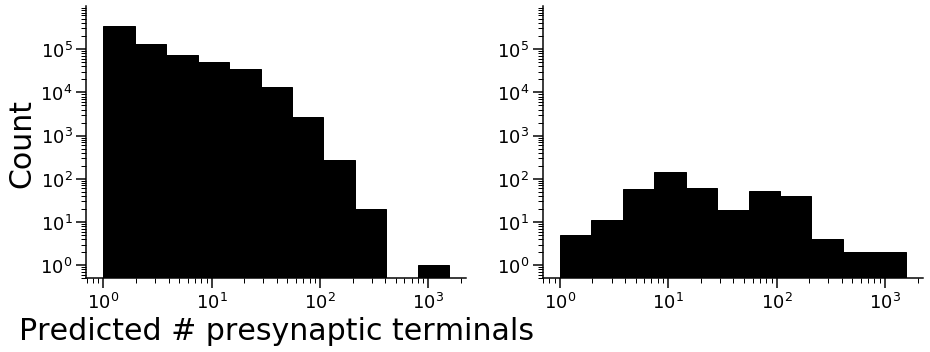

In [22]:
plt.figure(figsize=(15, 5))
bins = u.logspace_bins(df_m.pre_syns, 12)

splithist(df_m, "pre_syns", ["presyn", "soma"],
          bins=bins, colors=["k", "k", 'k'],
          xlbl="Predicted # presynaptic terminals",
          fontsize=30, ylim=ylim)
plt.show()